## 基于多智能模型集成的海洋气象预测方法的研究


## 海雾数据挖掘与分析

In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import interp1d
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import load_digits


import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 数据格式

Features：(41740,72,9,10)，每个样本有9个点，10个要素


Labels：（41740,）每个样本的可见度


中心点：9个一组，Label只考虑中心点的10个要素


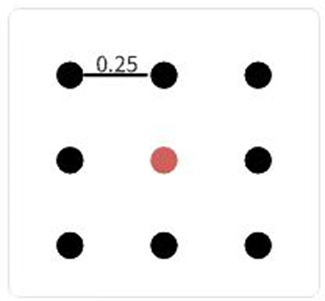

### 数据导入

In [23]:
# data = np.load('./Data/test.npz')
data = np.load('./Data/test.npz')
Features = data['x']
Labels = data['y']

In [24]:
print(Features.shape,Labels.shape)

(16871, 72, 9, 10) (16871,)


新增特征：海温露点差，比湿

In [4]:
def saturation_vapor_pressure(T):
    # T is the dew point temperature in Celsius
    return 6.112 * np.exp((17.67 * T) / (T + 243.5))

def specific_humidity(d2m, sp):
    # d2m: Dew point temperature in Celsius
    # sp: Surface pressure in Pa
    e = saturation_vapor_pressure(d2m)
    # Calculate specific humidity
    q = 0.622 * e / (sp - e)
    return q

In [5]:
# 假设 Features 是您的原始数据数组
num_samples, num_timesteps, num_spatial_locs, num_features = Features.shape

# 初始化一个新的数组来包含两个新的特征
new_features = np.empty((num_samples, num_timesteps, num_spatial_locs, 2))

# 海温露点差和比湿计算
for i in range(num_samples):
    for j in range(num_timesteps):
        for k in range(num_spatial_locs):
            d2m = Features[i, j, k, 0]  # 露点温度
            sst = Features[i, j, k, 4]  # 海表温度
            sp = Features[i, j, k, 5]  # 表面压力

            # 计算海温露点差
            sea_dew_temp_diff = sst - d2m
            
            # 计算比湿
            specific_hum = specific_humidity(d2m, sp * 100)  # sp 转换为帕斯卡

            # 存储新特征
            new_features[i, j, k, 0] = sea_dew_temp_diff
            new_features[i, j, k, 1] = specific_hum

# 将新特征拼接到原始特征数组
expanded_features = np.concatenate((Features, new_features), axis=3)

In [6]:
print(expanded_features.shape)

(16871, 72, 9, 12)


In [7]:
Features = expanded_features

### 异常值检测

In [4]:
# 检查缺失值
missing_values = np.isnan(Features)

# 计算缺失值的数量
num_missing_values = np.sum(missing_values)

print("Total missing values in Features:", num_missing_values)

# 如果有缺失值，输出它们的位置
if num_missing_values > 0:
    # np.where() 可以返回缺失值的准确位置
    missing_value_positions = np.where(missing_values)
    print("Positions of missing values:", missing_value_positions)

Total missing values in Features: 0


In [5]:
# 检查异常值，用 Z 分数方法检测异常值
z_scores = np.abs(stats.zscore(Features, axis=None))  # 计算所有数据的 Z 分数
outliers = z_scores > 3

print("Total outliers in Features:", np.sum(outliers))

# 如果有异常值，输出它们的位置
if np.sum(outliers) > 0:
    outlier_positions = np.where(outliers)
    print("Positions of outliers:", outlier_positions)

Total outliers in Features: 114264
Positions of outliers: (array([   90,    90,    90, ..., 16849, 16849, 16849], dtype=int64), array([ 0,  0,  0, ..., 71, 71, 71], dtype=int64), array([0, 1, 2, ..., 0, 1, 2], dtype=int64), array([4, 4, 4, ..., 4, 4, 4], dtype=int64))


### 数据标准化

In [25]:
# 检查每个特征的平均值和标准差
mean_vals = np.mean(Features, axis=(0, 1, 2))
std_vals = np.std(Features, axis=(0, 1, 2))

print("Mean values before standardization:", mean_vals)
print("Std values before standardization:", std_vals)

Mean values before standardization: [ 2.78983056e+02 -5.10798900e-05  2.43039977e+01  1.01300906e+05
  1.04196789e+35  1.01270467e+05  1.42010698e-04  8.46983597e+01
  2.59474865e+00  1.34331384e+00]
Std values before standardization: [6.71750427e+00 8.70541260e-05 1.73084665e+02 1.15341963e+03
 1.01385536e+36 1.17919649e+03 4.35350302e-04 1.37074054e+01
 7.16587588e+00 7.02570845e+00]


In [26]:
Features_standardized = []
# 若数据未标准化，则进行标准化，如果所有特征的平均值接近0且标准差接近1，则它们已被标准化
if not (np.allclose(mean_vals, 0, atol=0.1) and np.allclose(std_vals, 1, atol=0.1)):
    # 因为数据是四维的，我们需要先将其转换为二维，以便使用StandardScaler
    num_samples, hours, points, features = Features.shape
    Features_reshaped = Features.reshape(-1, features)
    
    scaler = StandardScaler()
    Features_standardized = scaler.fit_transform(Features_reshaped)
    
    # 将标准化后的数据重新变换回原始的四维形状
    Features_standardized = Features_standardized.reshape(num_samples, hours, points, features)
    
    # 再次检查平均值和标准差
    mean_vals_after = np.mean(Features_standardized, axis=(0, 1, 2))
    std_vals_after = np.std(Features_standardized, axis=(0, 1, 2))
    
    print("Mean values after standardization:", mean_vals_after)
    print("Std values after standardization:", std_vals_after)
else:
    print("Data is already standardized.")
    Features_standardized = Features

Mean values after standardization: [-2.59818079e-15  1.25146737e-13 -2.16582160e-12  2.05751726e-15
  4.00546680e-13  1.64086581e-15 -3.09835325e-13 -2.22190473e-15
 -5.36744813e-15  5.00857403e-15]
Std values after standardization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 相关性分析

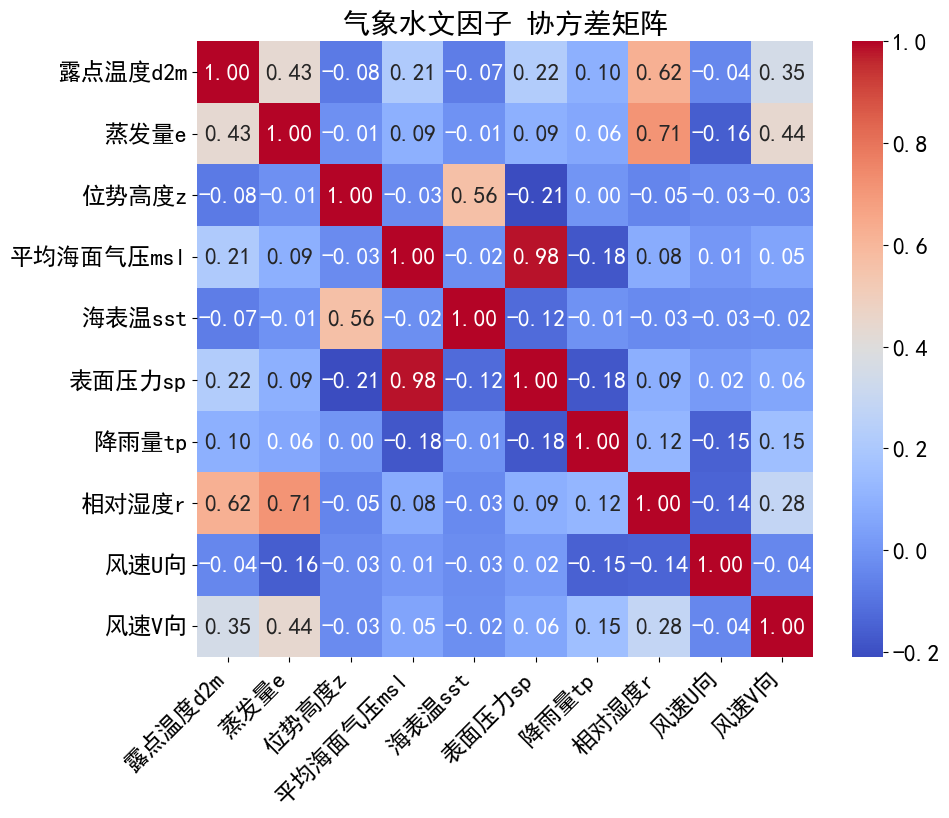

In [9]:
# 整合为二维
plt.rcParams.update({'font.size': 17})
num_samples, hours, points, features = Features_standardized.shape
Features_reshaped = Features_standardized.reshape(-1, features)
scaler = StandardScaler()
Matrix_for_Check = scaler.fit_transform(Features_reshaped)

# 指定变量名
variable_names = ['露点温度d2m', '蒸发量e', '位势高度z', '平均海面气压msl', '海表温sst', '表面压力sp', '降雨量tp', '相对湿度r', '风速U向', '风速V向']

# 将 NumPy 数组转换为 DataFrame，并指定列名
df = pd.DataFrame(Matrix_for_Check, columns=variable_names)

# 计算协方差矩阵，确保 rowvar=False 来按变量（列）计算协方差
covariance_matrix = np.cov(df, rowvar=False)

# 使用 seaborn 绘制协方差矩阵的热力图
plt.figure(figsize=(10, 8))  # 设置图形的大小
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, 
            xticklabels=variable_names, yticklabels=variable_names)
plt.title('气象水文因子 协方差矩阵')  # 设置热力图的标题
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好阅读
plt.yticks(rotation=0)  # 调整 y 轴标签角度
plt.show()  # 显示图形

In [11]:
# VIF计算，判断相关性，一般认为大于10时严重共线
X = add_constant(Matrix_for_Check)

# 计算每个变量的VIF值，并存储到一个列表中
vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# 输出VIF值
print(vif_values)

[0.9999999999999991, 1.9024282028079083, 2.395999615387081, 989.9044297848563, 28318.78972482954, 1.4699892491765276, 29626.113205843052, 1.1040471944226469, 2.82590234667972, 1.05578237425515, 1.3603146829438573]


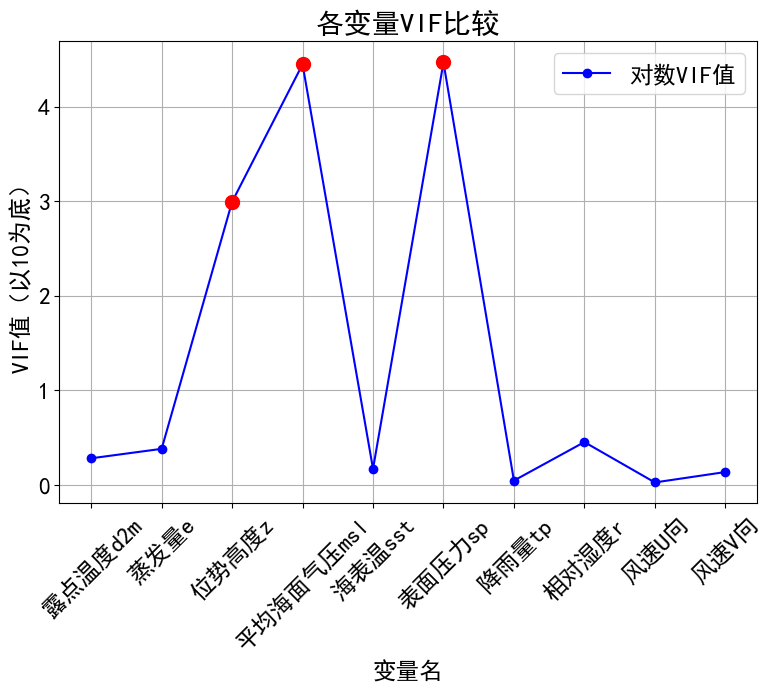

In [12]:
# 移除常数项的VIF
vif_values = vif_values[1:]
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl','海表温sst','表面压力sp', '降雨量tp','相对湿度r','风速U向','风速V向']


# 设置VIF值的高值标准，比如10
vif_threshold = 10

# 取以10为底的对数
log_vif_values = np.log10(vif_values)

# 绘制折线图
plt.figure(figsize=(9, 6))
plt.plot(variable_names, log_vif_values, marker='o', color='blue', label='对数VIF值')

# 对于高于阈值的VIF值，在折线图上标记红色圆圈
for i, log_vif in enumerate(log_vif_values):
    if vif_values[i] > vif_threshold:  # 比较原始VIF值
        plt.plot(variable_names[i], log_vif, marker='o', markersize=10, color='red')

# 添加网格线
plt.grid(True)

# 添加图例
plt.legend()

# 设置图的标题和轴标签
plt.title('各变量VIF比较')
plt.xlabel('变量名')
plt.ylabel('VIF值（以10为底）')

# 旋转x轴的标签，以便更好地阅读
plt.xticks(rotation=45)

# 显示图表
plt.show()

分析得出，msl与sp可选其一，因此选择舍弃VIF值更高的sp

In [27]:
Features_standardized_Modified = np.delete(Features_standardized, 5, axis=3)
# Features_standardized_Modified = np.delete(Features_standardized_Modified, 4, axis=3)
print(Features_standardized_Modified.shape)

(16871, 72, 9, 9)


In [20]:
# 整合为二维
num_samples, hours, points, features = Features_standardized_Modified.shape
Features_reshaped = Features_standardized_Modified.reshape(-1, features)
scaler = StandardScaler()
Matrix_for_Check = scaler.fit_transform(Features_reshaped)

X = add_constant(Matrix_for_Check)
vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# 输出VIF值
print(vif_values)

[0.9999999999999749, 1.8391924624530434, 2.393435119938441, 1.47116116059837, 1.1002734091034985, 1.467059764830144, 1.1038523398230031, 2.8223278614487155, 1.0554083870169026, 1.3601415081633983]


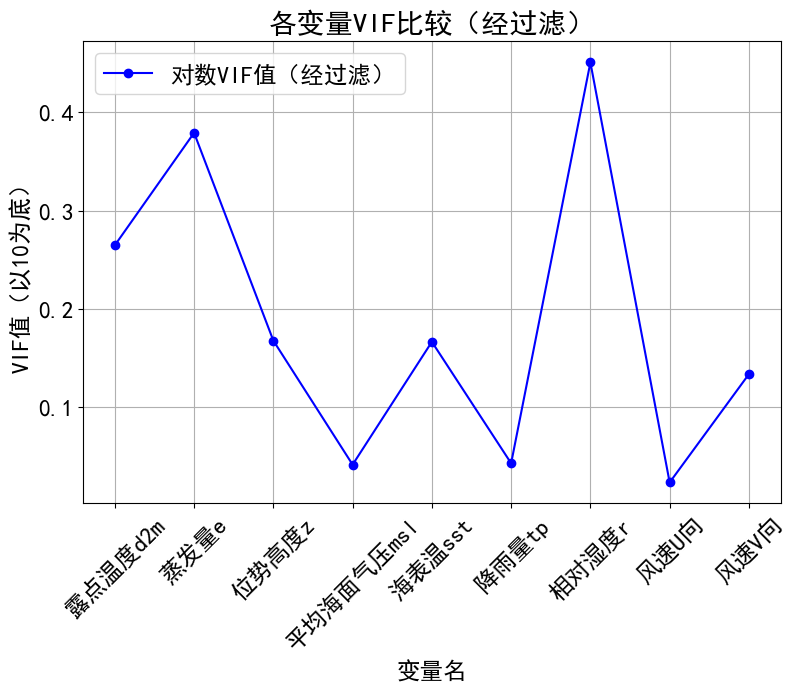

In [21]:
# 移除常数项的VIF
vif_values = vif_values[1:]
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl','海表温sst', '降雨量tp','相对湿度r','风速U向','风速V向']


# 设置VIF值的高值标准，比如10
vif_threshold = 10

# 取以10为底的对数
log_vif_values = np.log10(vif_values)

# 绘制折线图
plt.figure(figsize=(9, 6))
plt.plot(variable_names, log_vif_values, marker='o', color='blue', label='对数VIF值（经过滤）')

# 对于高于阈值的VIF值，在折线图上标记红色圆圈
for i, log_vif in enumerate(log_vif_values):
    if vif_values[i] > vif_threshold:  # 比较原始VIF值
        plt.plot(variable_names[i], log_vif, marker='o', markersize=10, color='red')

# 添加网格线
plt.grid(True)

# 添加图例
plt.legend()

# 设置图的标题和轴标签
plt.title('各变量VIF比较（经过滤）')
plt.xlabel('变量名')
plt.ylabel('VIF值（以10为底）')

# 旋转x轴的标签，以便更好地阅读
plt.xticks(rotation=45)

# 显示图表
plt.show()

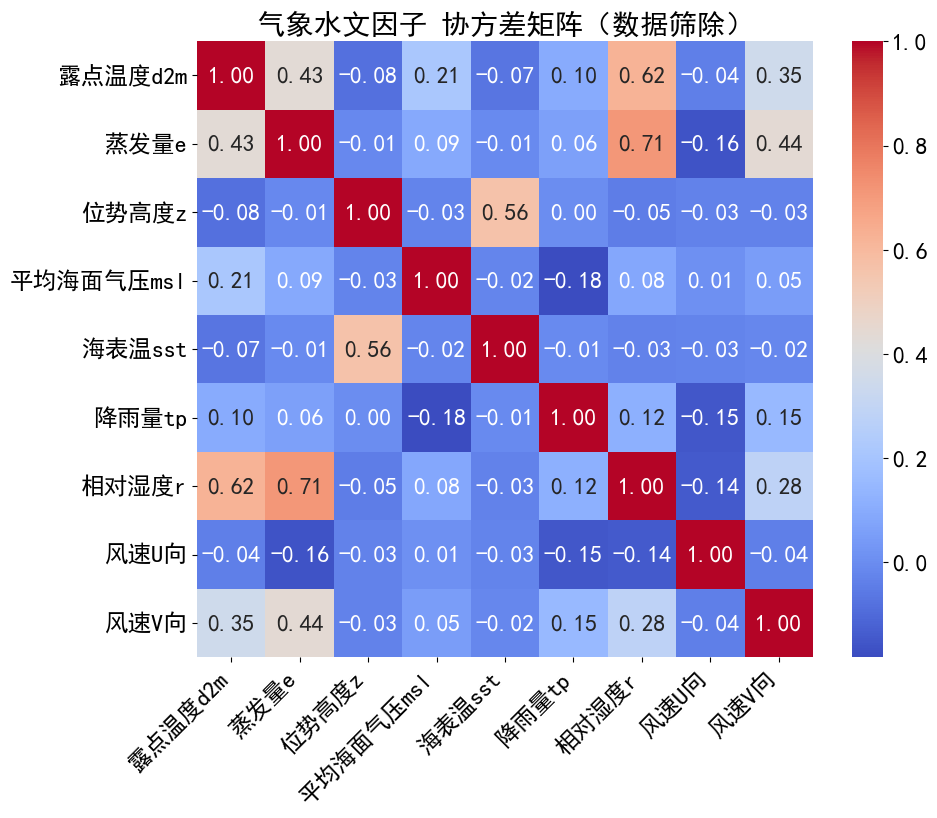

In [16]:
# 整合为二维
num_samples, hours, points, features = Features_standardized_Modified.shape
Features_reshaped = Features_standardized_Modified.reshape(-1, features)
scaler = StandardScaler()
Matrix_for_Check = scaler.fit_transform(Features_reshaped)

# 指定变量名
variable_names = ['露点温度d2m', '蒸发量e', '位势高度z', '平均海面气压msl', '海表温sst',  '降雨量tp', '相对湿度r', '风速U向', '风速V向']

# 将 NumPy 数组转换为 DataFrame，并指定列名
df = pd.DataFrame(Matrix_for_Check, columns=variable_names)

# 计算协方差矩阵，确保 rowvar=False 来按变量（列）计算协方差
covariance_matrix = np.cov(df, rowvar=False)

# 使用 seaborn 绘制协方差矩阵的热力图
plt.figure(figsize=(10, 8))  # 设置图形的大小
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, 
            xticklabels=variable_names, yticklabels=variable_names)
plt.title('气象水文因子 协方差矩阵（数据筛除）')  # 设置热力图的标题
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签以便更好阅读
plt.yticks(rotation=0)  # 调整 y 轴标签角度
plt.show()  # 显示图形

### 时序数据重构

In [29]:
# 创建原始时间点 (72个时间点)
original_time_points = np.arange(72)
new_time_points = np.linspace(0, 71, num=720)
Features_interpolated = Features_standardized_Modified.reshape(16871*9, 72, 9)

print(Features_standardized_Modified[0,0,0,:])
print(Features_interpolated[0,0,:])

[-1.93537787 -0.84699762 -0.1449618   0.07402622 -0.10277283  0.02581743
 -2.49175262  1.39625353  0.07087357]
[-1.93537787 -0.84699762 -0.1449618   0.07402622 -0.10277283  0.02581743
 -2.49175262  1.39625353  0.07087357]


In [30]:
print(Features_interpolated.shape)

(151839, 72, 9)


In [31]:
# 一阶差分
Features_Diff_1 = np.diff(Features_interpolated, axis=1)
Features_Diff_1_Initial = Features_interpolated[:, 0, :]

# 二阶差分
Features_Diff_2 = np.diff(Features_Diff_1, axis=1)
Features_Diff_2_Initial = Features_Diff_1[:, 0, :]

# 保存差分数据和初始值
np.savez('DataSet/Features_Diff_0.npz', Features_Diff_0=Features_interpolated)
np.savez('DataSet/Features_Diff_1.npz', Features_Diff_1=Features_Diff_1)
np.savez('DataSet/Features_Diff_1_Initial.npz', Features_Diff_1_Initial=Features_Diff_1_Initial)
np.savez('DataSet/Features_Diff_2.npz', Features_Diff_2=Features_Diff_2)
np.savez('DataSet/Features_Diff_2_Initial.npz', Features_Diff_2_Initial=Features_Diff_2_Initial)

In [13]:
print(Features_Diff_1.shape, Features_Diff_2.shape)

(151839, 71, 8) (151839, 70, 8)


供多分类器使用的判别海雾数据

In [ ]:
# Final_Step_Data = Features_standardized_Modified[:,-1,4,:]
Final_Step_Data = Features_standardized_Modified[:,-4:-1,4,:]
print(Final_Step_Data.shape)

(41740, 3, 9)


In [ ]:
llabels = [1 if i <= 4 else 0 for i in Labels]
np.savez('DataSet/Classified_Data.npz', features = Final_Step_Data, labels=llabels)

In [ ]:
Final_Step_Data = Features_standardized_Modified[:,-3,:,:]
# 初始化一个 (41740, 3, 3, 9) 的数组来存储最终结果
final_matrix_3 = np.zeros((16871, 3, 3, 9), dtype=int)

# 对每一个 (9, 9) 的矩阵进行处理
for i in range(Final_Step_Data.shape[0]):
    for j in range(9):  # 遍历每一列
        # 将第 j 列重塑为 (3, 3)
        final_matrix_3[i, :, :, j] = Final_Step_Data[i, :, j].reshape(3, 3)

final_matrix_3 = final_matrix_3.transpose(0,3,1,2)
print(final_matrix_3.shape)

(16871, 9, 3, 3)


In [ ]:
Final_Step_Data = Features_standardized_Modified[:,-2,:,:]
# 初始化一个 (41740, 3, 3, 9) 的数组来存储最终结果
final_matrix_2 = np.zeros((16871, 3, 3, 9), dtype=int)

# 对每一个 (9, 9) 的矩阵进行处理
for i in range(Final_Step_Data.shape[0]):
    for j in range(9):  # 遍历每一列
        # 将第 j 列重塑为 (3, 3)
        final_matrix_2[i, :, :, j] = Final_Step_Data[i, :, j].reshape(3, 3)

final_matrix_2 = final_matrix_2.transpose(0,3,1,2)
print(final_matrix_2.shape)

(16871, 9, 3, 3)


In [ ]:
Final_Step_Data = Features_standardized_Modified[:,-1,:,:]
# 初始化一个 (41740, 3, 3, 9) 的数组来存储最终结果
final_matrix_1 = np.zeros((16871, 3, 3, 9), dtype=int)

# 对每一个 (9, 9) 的矩阵进行处理
for i in range(Final_Step_Data.shape[0]):
    for j in range(9):  # 遍历每一列
        # 将第 j 列重塑为 (3, 3)
        final_matrix_1[i, :, :, j] = Final_Step_Data[i, :, j].reshape(3, 3)

final_matrix_1 = final_matrix_1.transpose(0,3,1,2)
print(final_matrix_1.shape)


(16871, 9, 3, 3)


In [ ]:
combined_matrix = np.concatenate([final_matrix_3, final_matrix_2, final_matrix_1], axis=1)
print("Shape of the combined matrix:", combined_matrix.shape)

Shape of the combined matrix: (16871, 27, 3, 3)


In [45]:
llabels = [1 if i <= 4 else 0 for i in Labels]
np.savez('DataSet/Classified_Data_zone.npz', features = final_matrix_1, labels=llabels)

In [9]:
Final_Step_Data_1 = Features_standardized[:,-1,4,:]
Final_Step_Data_2 = Features_standardized[:,-2,4,:]
Final_Step_Data_3 = Features_standardized[:,-3,4,:]

Final_Step_Data_diff = []
for i in range(len(Final_Step_Data_1)):
    SET = []
    SET.extend(list(Final_Step_Data_3[i]))
    SET.extend(list(Final_Step_Data_2[i]))
    SET.extend(list(Final_Step_Data_1[i]))
    Final_Step_Data_diff.append(SET)

Final_Step_Data_diff = np.array(Final_Step_Data_diff)
print(Final_Step_Data_diff.shape)
llabels = [1 if i <= 4 else 0 for i in Labels]
np.savez('DataSet/Classified_Data.npz', features = Final_Step_Data_diff, labels=llabels)

(41740, 30)


In [20]:
Final_Step_Data_diff = Features_standardized_Modified[:,-1,4,:]
print(Final_Step_Data_diff.shape)

(16871, 9)


In [27]:
Index = [0,1,3,6,8]
Data_Split = Final_Step_Data_diff[:,Index]
Data_Split = (Data_Split[:,1] - Data_Split[:,0]) / (Data_Split[:,2]**1.75)

C:\Users\14390\AppData\Local\Temp\ipykernel_33776\3173213772.py:3: RuntimeWarning: invalid value encountered in power
  Data_Split = (Data_Split[:,1] - Data_Split[:,0]) / (Data_Split[:,2]**1.75)


In [21]:
llabels = [1 if i <= 4 else 0 for i in Labels]
np.savez('DataSet/Classified_Data.npz', features = Final_Step_Data_diff, labels=llabels)

In [26]:
# 转换为DataFrame
df = pd.DataFrame(Final_Step_Data_diff, columns=[f'Feature_{i}' for i in range(0, 11)])
df['Label'] = Labels

# 计算每个特征与标签的相关系数
correlations = df.corr()['Label'].drop('Label')  # 删除标签自身的相关性条目
print(correlations)

Feature_0    -0.403522
Feature_1    -0.505617
Feature_2     0.077517
Feature_3    -0.290304
Feature_4     0.044678
Feature_5     0.028440
Feature_6    -0.541056
Feature_7     0.041768
Feature_8    -0.246255
Feature_9     0.044678
Feature_10   -0.375428
Name: Label, dtype: float64
